In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer.datasets as md
from pymatgen.core import Composition
from matminer.featurizers.composition.element import ElementFraction
from matminer.datasets.dataset_retrieval import load_dataset
from matminer.featurizers.conversions import StrToComposition
from sklearn.ensemble import RandomForestRegressor
from matplotlib.colors import LogNorm
from sklearn import metrics

In [7]:
from matminer.datasets import load_dataset
df = load_dataset("jarvis_dft_3d")

In [8]:
df.shape[0]

25923

In [31]:
df.head()

,epsilon_x opt,epsilon_y opt,epsilon_z opt,structure,e_form,shear modulus,structure initial,jid,bulk modulus,gap tbmbj,epsilon_x tbmbj,epsilon_y tbmbj,epsilon_z tbmbj,mpid,gap opt,composition
0,NaN,NaN,NaN,"[[1.40094192 1.40094192 1.40094192] Co, [0. 0....",0.161,71.22,"[[1.4010965 1.4010965 1.4010965] Co, [0. 0. 0....",JVASP-11946,196.200,NaN,NaN,NaN,NaN,mp-1006883,0.0016,"(Co, Ni)"
1,NaN,NaN,NaN,"[[1.75548056 1.75548056 0. ] Co, [1.755...",0.006,116.92,"[[1.7570355 1.7570355 0. ] Co, [1.757035...",JVASP-11947,209.367,NaN,NaN,NaN,NaN,mp-1008349,0.0018,"(Co, Ni)"
2,NaN,NaN,NaN,"[[0. 0. 0.] Nb, [1.54076297 1.54076297 1.54076...",-0.014,-4.58,"[[0. 0. 0.] Nb, [1.541015 1.541015 1.541015] Co]",JVASP-11948,200.067,NaN,NaN,NaN,NaN,mp-1009264,0.0019,"(Nb, Co)"
3,42.9249,42.9249,42.9249,"[[0. 0. 0.] Mg, [1.51711798 1.51711798 1.51711...",-0.210,42.96,"[[0. 0. 0.] Mg, [1.5232265 1.5232265 1.5232265...",JVASP-11949,92.700,NaN,NaN,NaN,NaN,mp-1010953,0.0098,"(Mg, Ni)"
4,44.0749,44.0749,61.1827,"[[0. 0. 0.] Al, [-2.35662665e-06 2.33379406e+...",-0.648,NaN,"[[0. 0. 0.] Al, [-2.34789400e-06 2.32621516e+...",JVASP-11950,NaN,NaN,NaN,NaN,NaN,mp-1057,0.0143,"(Al, Ni)"


In [6]:
mask = df["gap opt"] > 0
df = df[mask]
df.shape[0]

23439

In [33]:
columns_remove = ['epsilon_x opt' , 'epsilon_y opt', 'epsilon_z opt', 'e_form', 'shear modulus', 'structure initial', 'jid', 'bulk modulus', 'gap tbmbj', 'epsilon_x tbmbj', 'epsilon_y tbmbj', 'epsilon_z tbmbj']
df = df.drop(columns_remove, axis=1)


In [34]:
df.head()

,structure,mpid,gap opt,composition
0,"[[1.40094192 1.40094192 1.40094192] Co, [0. 0....",mp-1006883,0.0016,"(Co, Ni)"
1,"[[1.75548056 1.75548056 0. ] Co, [1.755...",mp-1008349,0.0018,"(Co, Ni)"
2,"[[0. 0. 0.] Nb, [1.54076297 1.54076297 1.54076...",mp-1009264,0.0019,"(Nb, Co)"
3,"[[0. 0. 0.] Mg, [1.51711798 1.51711798 1.51711...",mp-1010953,0.0098,"(Mg, Ni)"
4,"[[0. 0. 0.] Al, [-2.35662665e-06 2.33379406e+...",mp-1057,0.0143,"(Al, Ni)"


AttributeError: 'numpy.ndarray' object has no attribute 'x_label'

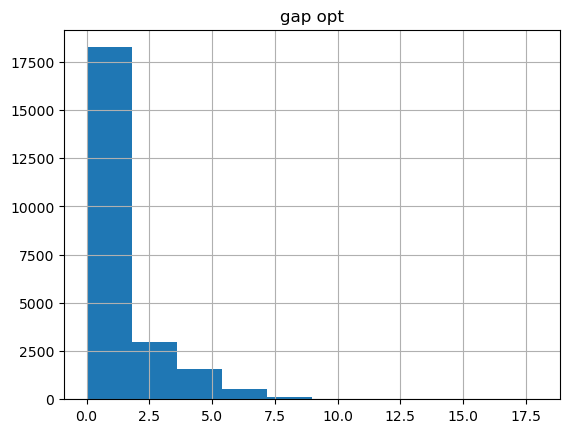

In [40]:
hist = df.hist(column ='gap opt')

In [41]:
#featurize compositions using magpie preset
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition")  # input the "composition" column to the featurizer
df.head()

ElementProperty:   0%|          | 0/23439 [00:00<?, ?it/s]

,structure,mpid,gap opt,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,"[[1.40094192 1.40094192 1.40094192] Co, [0. 0....",mp-1006883,0.0016,"(Co, Ni)",27.0,28.0,1.0,27.50,0.500,27.0,...,0.953076,1.071933,0.476538,0.595395,194.0,225.0,31.0,209.50,15.500,194.0
1,"[[1.75548056 1.75548056 0. ] Co, [1.755...",mp-1008349,0.0018,"(Co, Ni)",27.0,28.0,1.0,27.25,0.375,27.0,...,0.953076,1.310202,0.357404,1.548471,194.0,225.0,31.0,201.75,11.625,194.0
2,"[[0. 0. 0.] Nb, [1.54076297 1.54076297 1.54076...",mp-1009264,0.0019,"(Nb, Co)",27.0,41.0,14.0,34.00,7.000,27.0,...,1.548471,0.774236,0.774236,0.000000,194.0,229.0,35.0,211.50,17.500,194.0
3,"[[0. 0. 0.] Mg, [1.51711798 1.51711798 1.51711...",mp-1010953,0.0098,"(Mg, Ni)",12.0,28.0,16.0,20.00,8.000,12.0,...,0.595395,0.297697,0.297697,0.000000,194.0,225.0,31.0,209.50,15.500,194.0
4,"[[0. 0. 0.] Al, [-2.35662665e-06 2.33379406e+...",mp-1057,0.0143,"(Al, Ni)",13.0,28.0,15.0,19.00,7.200,13.0,...,0.595395,0.238158,0.285789,0.000000,225.0,225.0,0.0,225.00,0.000,225.0


In [42]:
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates

df = CompositionToOxidComposition().featurize_dataframe(df, "composition")

os_feat = OxidationStates()
df = os_feat.featurize_dataframe(df, "composition_oxid")
df.head()

CompositionToOxidComposition:   0%|          | 0/23439 [00:00<?, ?it/s]

/Users/saagarkolachina/miniconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/saagarkolachina/miniconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/saagarkolachina/miniconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/saagarkolachina/miniconda3/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity 

ValueError: Composition Se36 W17 Nb1 cannot accommodate max_sites setting!
TO SKIP THESE ERRORS when featurizing specific compounds, set 'ignore_errors=True' when running the batch featurize() operation (e.g., featurize_many(), featurize_dataframe(), etc.).

In [43]:
#structure based features
from matminer.featurizers.structure import DensityFeatures

df_feat = DensityFeatures()
df = df_feat.featurize_dataframe(df, "structure", ignore_errors=True)  # input the structure column to the featurizer
df.head()

DensityFeatures:   0%|          | 0/23439 [00:00<?, ?it/s]

,structure,mpid,gap opt,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
0,"[[1.40094192 1.40094192 1.40094192] Co, [0. 0....",mp-1006883,0.0016,"(Co, Ni)",27.0,28.0,1.0,27.50,0.500,27.0,...,0.595395,194.0,225.0,31.0,209.50,15.500,194.0,8.879822,10.998169,0.937065
1,"[[1.75548056 1.75548056 0. ] Co, [1.755...",mp-1008349,0.0018,"(Co, Ni)",27.0,28.0,1.0,27.25,0.375,27.0,...,1.548471,194.0,225.0,31.0,201.75,11.625,194.0,9.035434,10.819771,0.952515
2,"[[0. 0. 0.] Nb, [1.54076297 1.54076297 1.54076...",mp-1009264,0.0019,"(Nb, Co)",27.0,41.0,14.0,34.00,7.000,27.0,...,0.000000,194.0,229.0,35.0,211.50,17.500,194.0,8.616613,14.630780,0.788613
3,"[[0. 0. 0.] Mg, [1.51711798 1.51711798 1.51711...",mp-1010953,0.0098,"(Mg, Ni)",12.0,28.0,16.0,20.00,8.000,12.0,...,0.000000,194.0,225.0,31.0,209.50,15.500,194.0,4.933678,13.967480,0.875003
4,"[[0. 0. 0.] Al, [-2.35662665e-06 2.33379406e+...",mp-1057,0.0143,"(Al, Ni)",13.0,28.0,15.0,19.00,7.200,13.0,...,0.000000,225.0,225.0,0.0,225.00,0.000,225.0,4.738675,13.899965,0.649724


In [44]:
#remove any rows that have feature values of 'NaN'
data = df.dropna()

In [46]:
data.size

3255797

In [47]:
#start machine learning

In [53]:
y = data['gap opt'].values
remove = ['structure', 'mpid', 'composition', 'gap opt']
X = data.drop(remove, axis=1)

In [55]:
#Split into Training and Testing Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

In [56]:
model_rf = RandomForestRegressor(n_estimators = 150, random_state=1)

In [57]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=1)

In [58]:
y_predrf = model_rf.predict(X_test)

In [60]:
from sklearn.metrics import mean_squared_error, r2_score

In [64]:
print('Testing MSE:\t'+str(mean_squared_error(y_test, y_predrf))+'\n')
print('Testing R2\t'+str(r2_score(y_test, y_predrf))+'\n')

Testing MSE:	0.3459964660926981

Testing R2	0.867766902254969



In [65]:
#Parity Plots
import matplotlib.pyplot as plt

Text(0, 0.5, 'RF Bandgap')

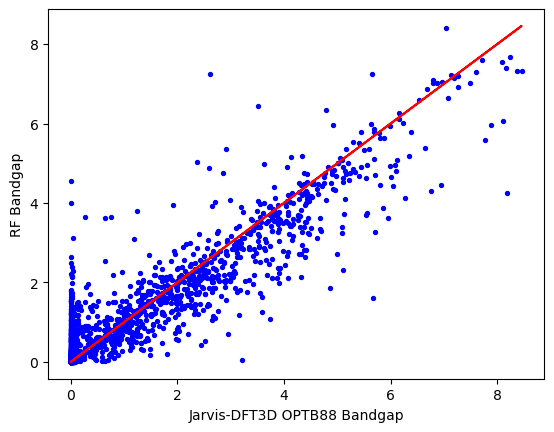

In [79]:
plt.scatter(y_test, y_predrf, s = 8, color = 'blue')
plt.plot(y_test, y_test, color = 'red')
plt.xlabel('Jarvis-DFT3D OPTB88 Bandgap')
plt.ylabel('RF Bandgap')

In [77]:
#actually get rid of non-metals (same # - dismiss)
print(data.shape[0])
data_nonmetals = data[data['gap opt'] != 0]

23423
23423


In [78]:
#Want to find out ways to increase model performance, will explore a couple:
# - Fitting data to a different model (Gradient Boosting)
# - Hyperparameter Optimization 
# - Evaluate performance with k-fold cross validation

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
model_gb = GradientBoostingRegressor(n_estimators = 150, random_state = 123)

In [83]:
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=150, random_state=123)

In [88]:
y_predgb = model_gb.predict(X_test)

In [89]:
print('Testing MSE:\t'+str(mean_squared_error(y_test, y_predgb))+'\n')
print('Testing R2\t'+str(r2_score(y_test, y_predgb))+'\n')

Testing MSE:	0.5736713631372953

Testing R2	0.7807539993343877



Text(0, 0.5, 'GB Bandgap')

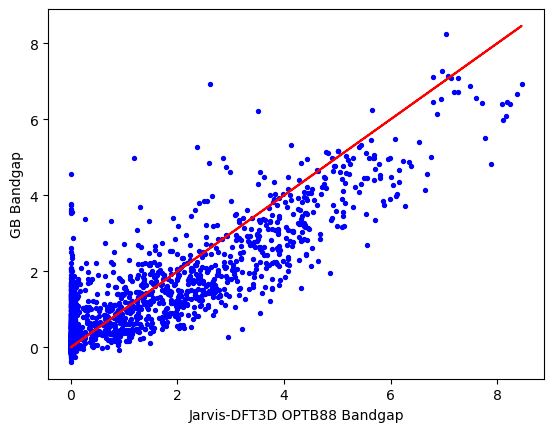

In [90]:
plt.scatter(y_test, y_predgb, s = 8, color = 'blue')
plt.plot(y_test, y_test, color = 'red')
plt.xlabel('Jarvis-DFT3D OPTB88 Bandgap')
plt.ylabel('GB Bandgap')

In [91]:
#Gradient Boosting Performing Worse, will try to hyperparameterize Random Forest Model

In [92]:
#increase n_estimators
model_rf2 = RandomForestRegressor(n_estimators = 250, random_state=1)
model_rf2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=250, random_state=1)

In [93]:
y_predrf2 = model_rf2.predict(X_test)

In [94]:
print('Testing MSE:\t'+str(mean_squared_error(y_test, y_predrf2))+'\n')
print('Testing R2\t'+str(r2_score(y_test, y_predrf2))+'\n')

Testing MSE:	0.34594961851478934

Testing R2	0.8677848064850864



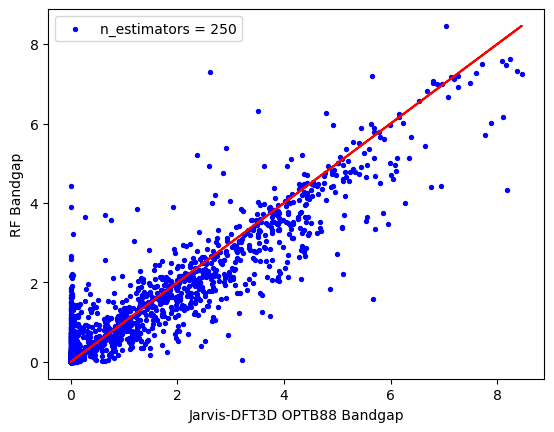

In [96]:
plt.scatter(y_test, y_predrf2, s = 8, color = 'blue', label = 'n_estimators = 250')
plt.plot(y_test, y_test, color = 'red')
plt.xlabel('Jarvis-DFT3D OPTB88 Bandgap')
plt.ylabel('RF Bandgap')
plt.legend()

In [97]:
#MeanSquareError is better(could be better) and R2 is still good but has largely remained the same
#Hyperparameterize # of features


139

In [98]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

In [99]:
model_gridsearch = GridSearchCV(RandomForestRegressor(n_estimators=175, n_jobs=-1),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))
#from matminer formation energy example

In [100]:
model_gridsearch.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(n_estimators=175, n_jobs=-1),
             param_grid={'max_features': range(8, 15)},
             scoring='neg_mean_squared_error')

In [102]:
y_predgs = model_gridsearch.predict(X_test)

In [103]:
model_gridsearch.best_score_

-0.31608677692163717

Text(0, 0.5, 'MSE ')

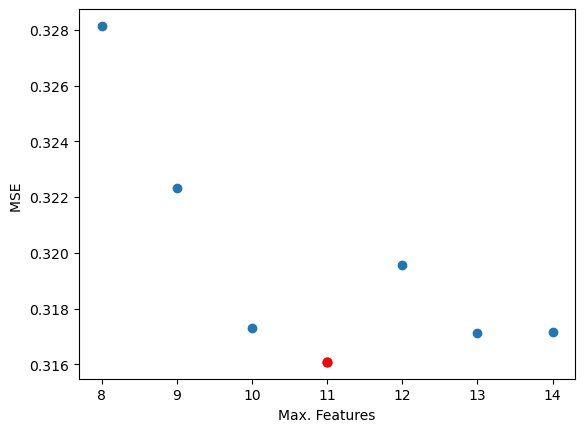

In [104]:

fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model_gridsearch.cv_results_['param_max_features'].data,
          (-1 * model_gridsearch.cv_results_['mean_test_score']))
ax.scatter([model_gridsearch.best_params_['max_features']], ([-1*model_gridsearch.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('MSE ')

#code from matminer formation energy example

In [105]:
model_gs1 = model_gridsearch.best_estimator_

In [116]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 25, 50],
    'max_features' : range(8,15) }
rf_gs = RandomForestRegressor()
model_gs2 = GridSearchCV(estimator=rf_gs, param_grid=param_grid, cv=ShuffleSplit(n_splits=1, test_size=0.1), scoring='neg_mean_squared_error')

In [117]:
model_gs2.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 25, 50],
                         'max_features': range(8, 15),
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [118]:
model_gs2_opt = model_gs2.best_estimator_

In [119]:
model_gs2_opt

RandomForestRegressor(max_features=13, n_estimators=300)

In [120]:
y_predictgs2 = model_gs2_opt.predict(X_test)

In [121]:
print('Testing MSE:\t'+str(mean_squared_error(y_test, y_predictgs2))+'\n')
print('Testing R2\t'+str(r2_score(y_test, y_predictgs2))+'\n')

Testing MSE:	0.34388555453224456

Testing R2	0.8685736514621408



Text(0.5, 1.0, 'hyperparameter optimization from grid search')

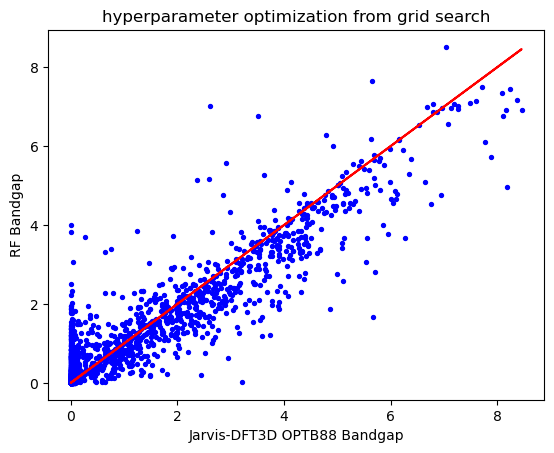

In [123]:
plt.scatter(y_test, y_predictgs2, s = 8, color = 'blue')
plt.plot(y_test, y_test, color = 'red')
plt.xlabel('Jarvis-DFT3D OPTB88 Bandgap')
plt.ylabel('RF Bandgap')
plt.title('hyperparameter optimization from grid search')

In [124]:
from sklearn.model_selection import cross_val_predict

In [126]:
#K-Fold Cross Validation
cv = cross_val_predict(model_gs2_opt, X_train, y_train, cv=KFold(10, shuffle=True))

Text(0, 0.5, 'RF BandGap')

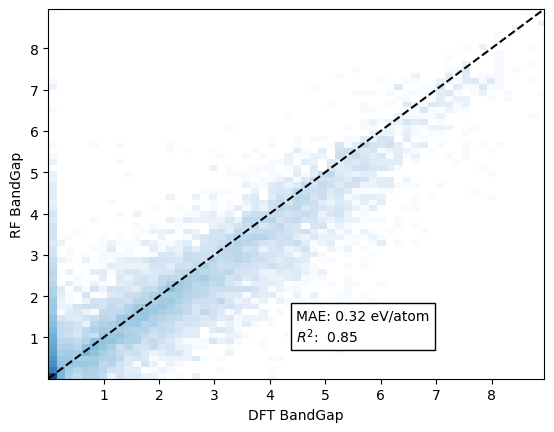

In [132]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(y_train), cv_prediction, norm=LogNorm(), bins=64, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(y_train, cv_prediction)
r2 = metrics.r2_score(y_train, cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT BandGap')
ax.set_ylabel('RF BandGap')

In [133]:
scores_1 = cross_val_score(model_gs2_opt, X_train, y_train, cv=KFold(10, shuffle=True))

In [134]:
scores_1

array([0.83893476, 0.85706196, 0.81555693, 0.88102612, 0.87040222,
       0.84125283, 0.83944581, 0.84519573, 0.83299526, 0.85328648])

In [137]:
print(scores_1.mean())
print(scores_1.std())

0.8475158101271048
0.017851447345007952


In [139]:
from matminer.datasets import load_dataset
df_ex = load_dataset('expt_gap')

In [141]:
df_ex.head()

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


In [144]:
data_nm = df_ex[df_ex['gap expt'] != 0]
#get rid of metals (still do not want it to be a classification problem)

In [146]:
print(data_nm.shape[0])
# of entries

3896


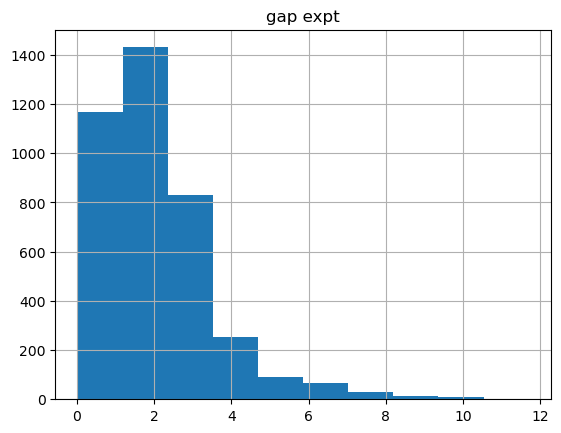

In [149]:
hist2 = data_nm.hist(column ='gap expt')

In [152]:
#only have formula and target property -> convert formula to composition and add magpie features
data_nm = StrToComposition().featurize_dataframe(data_nm, "formula")
data_nm.head()

,formula,gap expt,composition
0,Hg0.7Cd0.3Te,0.35,"(Hg, Cd, Te)"
1,CuBr,3.08,"(Cu, Br)"
2,LuP,1.30,"(Lu, P)"
3,Cu3SbSe4,0.40,"(Cu, Sb, Se)"
4,ZnO,3.44,"(Zn, O)"


In [155]:
ep_feat = ElementProperty.from_preset(preset_name="magpie")
data_nm = ep_feat.featurize_dataframe(data_nm, col_id="composition", ignore_errors = True)  # input the "composition" column to the featurizer
data_nm.head()

ElementProperty:   0%|          | 0/3896 [00:00<?, ?it/s]

,formula,gap expt,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Hg0.7Cd0.3Te,0.35,"(Hg, Cd, Te)",48.0,80.0,32.0,61.20,13.1600,52.0,70.0,...,0.000000,0.000000,0.000000,0.0,152.0,194.0,42.0,163.200,11.200,152.0
1,CuBr,3.08,"(Cu, Br)",29.0,35.0,6.0,32.00,3.0000,29.0,64.0,...,0.000000,0.000000,0.000000,0.0,64.0,225.0,161.0,144.500,80.500,64.0
2,LuP,1.30,"(Lu, P)",15.0,71.0,56.0,43.00,28.0000,15.0,41.0,...,0.002247,0.001124,0.001124,0.0,2.0,194.0,192.0,98.000,96.000,2.0
3,Cu3SbSe4,0.40,"(Cu, Sb, Se)",29.0,51.0,22.0,34.25,4.1875,34.0,64.0,...,0.000000,0.000000,0.000000,0.0,14.0,225.0,211.0,112.125,98.125,14.0
4,ZnO,3.44,"(Zn, O)",8.0,30.0,22.0,19.00,11.0000,8.0,69.0,...,0.000000,0.000000,0.000000,0.0,12.0,194.0,182.0,103.000,91.000,12.0


In [156]:
df_f = data_nm.dropna()

In [158]:
#of features
df_f.shape[1]

135

In [166]:
y_ex = df_f['gap expt'].values
remove = ['composition', 'gap expt', 'formula']
X_ex = df_f.drop(remove, axis=1)

In [167]:
X_ex.head()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,48.0,80.0,32.0,61.20,13.1600,52.0,70.0,90.0,20.0,80.350,...,0.000000,0.000000,0.000000,0.0,152.0,194.0,42.0,163.200,11.200,152.0
1,29.0,35.0,6.0,32.00,3.0000,29.0,64.0,95.0,31.0,79.500,...,0.000000,0.000000,0.000000,0.0,64.0,225.0,161.0,144.500,80.500,64.0
2,15.0,71.0,56.0,43.00,28.0000,15.0,41.0,83.0,42.0,62.000,...,0.002247,0.001124,0.001124,0.0,2.0,194.0,192.0,98.000,96.000,2.0
3,29.0,51.0,22.0,34.25,4.1875,34.0,64.0,89.0,25.0,79.125,...,0.000000,0.000000,0.000000,0.0,14.0,225.0,211.0,112.125,98.125,14.0
4,8.0,30.0,22.0,19.00,11.0000,8.0,69.0,87.0,18.0,78.000,...,0.000000,0.000000,0.000000,0.0,12.0,194.0,182.0,103.000,91.000,12.0


In [168]:
X_ex_train, X_ex_test, y_ex_train, y_ex_test = train_test_split(X_ex, y_ex, test_size=.1)

In [169]:
#RF Model
model_rfex = RandomForestRegressor(n_estimators = 300)

In [170]:
model_rfex.fit(X_ex_train, y_ex_train)

RandomForestRegressor(n_estimators=300)

In [171]:
yp_ex1 = model_rfex.predict(X_ex_test)

In [172]:
print('Testing MSE:\t'+str(mean_squared_error(y_ex_test, yp_ex1))+'\n')
print('Testing R2\t'+str(r2_score(y_ex_test, yp_ex1))+'\n')

Testing MSE:	0.2114629906188201

Testing R2	0.8857442771810636



In [ ]:
#Good looking results

Text(0, 0.5, 'RF Bandgap')

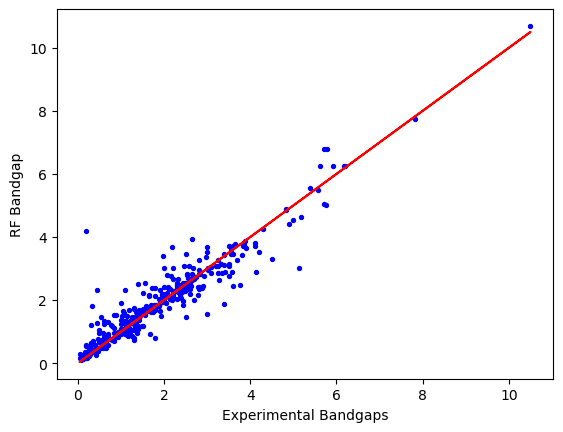

In [173]:
plt.scatter(y_ex_test, yp_ex1, s = 8, color = 'blue')
plt.plot(y_ex_test, y_ex_test, color = 'red')
plt.xlabel('Experimental Bandgaps')
plt.ylabel('RF Bandgap')


In [174]:
#Do some hyperparameter tuning:
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 25, 50],
    'max_features' : range(8,15) }
rf_exgs = RandomForestRegressor()
model_rfex_gs = GridSearchCV(estimator=rf_exgs, param_grid=param_grid, cv=ShuffleSplit(n_splits=1, test_size=0.1), scoring='neg_mean_squared_error')

In [175]:
model_rfex_gs.fit(X_ex_train, y_ex_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 25, 50],
                         'max_features': range(8, 15),
                         'n_estimators': [200, 300, 400]},
             scoring='neg_mean_squared_error')

In [176]:
model_rfex_opt = model_rfex_gs.best_estimator_

In [177]:
model_rfex_opt

RandomForestRegressor(max_depth=25, max_features=13, n_estimators=400)

In [178]:
yp_ex2 = model_rfex_opt.predict(X_ex_test)

In [179]:
print('Testing MSE:\t'+str(mean_squared_error(y_ex_test, yp_ex2))+'\n')
print('Testing R2\t'+str(r2_score(y_ex_test, yp_ex2))+'\n')

Testing MSE:	0.21019056193035737

Testing R2	0.8864317840545379



Text(0.5, 1.0, 'Optimized')

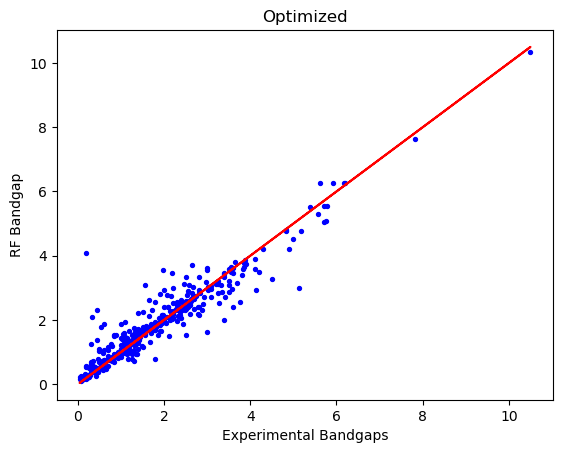

In [183]:
plt.scatter(y_ex_test, yp_ex2, s = 8, color = 'blue')
plt.plot(y_ex_test, y_ex_test, color = 'red')
plt.xlabel('Experimental Bandgaps')
plt.ylabel('RF Bandgap')
plt.title('Optimized')